In [8]:
from torch.utils.data import DataLoader
from torch import optim 
import torch.nn as nn
import torch

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

from loader import cityscapesDataset
from models import unet
from loader import utils
from loss import loss_metrics

In [2]:
np.random.seed(0)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Create DataSet, DataLoader, & Load Pretrained Model

In [4]:
cd = cityscapesDataset.CityscapesDataset("./data", split='train', target_type='semantic',
                               shrinkToSize=10, cropHeight=256, cropWidth=512)
cd2 = cityscapesDataset.CityscapesDataset("./data", split='val', target_type='semantic', shrinkToSize=10)
learner = unet.UNet(3, cd.n_classes).to(device=device)
# learner = unet.UNet(3, cd.n_classes)

In [5]:
bs = 2
n_workers=4
n_epochs = 5
lr = 0.0003
mom=0.9# Not used
wd = 0.01

In [6]:
dl_train = DataLoader(cd, batch_size=bs, num_workers=n_workers, pin_memory=True, shuffle=True)
dataiter = iter(dl_train)
dl_val = DataLoader(cd2, batch_size=bs, num_workers=n_workers, pin_memory=True, shuffle=True)

In [7]:
checkpoint = torch.load("saves/save103.pth")
learner.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
startEpoch = checkpoint['epoch']
# loss = checkpoint['loss']
print("Epoch ",startEpoch," Loaded.")

Epoch  103  Loaded.


### Implement Metrics & Losses

In [8]:
def accuracy(preds, lbls, ignore_class=None):
    
    pred = preds.cpu()
    lbl = lbls.cpu()
    
    if pred.shape!=lbl.shape:
        return -1  #incorrect shape
    
    if ignore_class is not None:
        unlabelled = lbl==ignore_class
        unlabelled_pixels = np.count_nonzero(unlabelled)
        del unlabelled
    else:
        unlabelled_pixels = 0
    
    total_pixels=1
    #calculate total pixels in batch
    for i in range(len(lbl.shape)):
        total_pixels *= lbl.shape[i]
        
    total_pixels -= unlabelled_pixels 
    
    # calculate pixels classified correctly
    correct_preds = lbl==pred
    correct_pixels = np.count_nonzero(correct_preds)
    
    del pred, lbl, correct_preds
    return correct_pixels/total_pixels

# source thread: https://discuss.pytorch.org/t/one-hot-encoding-with-autograd-dice-loss/9781/5
# preds - NxCxHxW
# target - NxHxW
def dice_loss_per_channel(pred, target, weights=None, ignore_index=None, eps=0.0001):
    
    #apply softmax to preds to make values in the range 0 .. 1
    softmax = nn.Softmax2d()
    pred = softmax(pred)
    
    # encoded_target will store one hot encoded target
    # useful documentation: https://pytorch.org/docs/stable/tensors.html#torch.Tensor.scatter_
    
    encoded_target = pred.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone() 
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
#     encoded_target = Variable(encoded_target)
        
    if weights is None:
        weights = 1
    
    # calculate numerator which represents intersection
    numerator = pred*encoded_target
    numerator = 2 * numerator.sum(0).sum(1).sum(1) # sum over samples(N), then HxW
    
    # calculte denominator which sums preds and encoded to represent union
    denominator = pred + encoded_target
    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps # sum over N, then HxW .. add eps for numerical stability
    
    loss_per_channel = weights * (1 - (numerator / denominator))
    
    del numerator, denominator
    return loss_per_channel

# wrapper method to be used for loss
def dice_loss(pred, target, weights=None, ignore_index=None, eps=0.0001):
    loss_per_channel = dice_loss_per_channel(pred, target, weights=weights, ignore_index=ignore_index, eps=eps)
    
    return loss_per_channel.sum()/pred.size(1)

### Try some predictions

C:\Users\risha\Anaconda3\envs\Rishabh\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


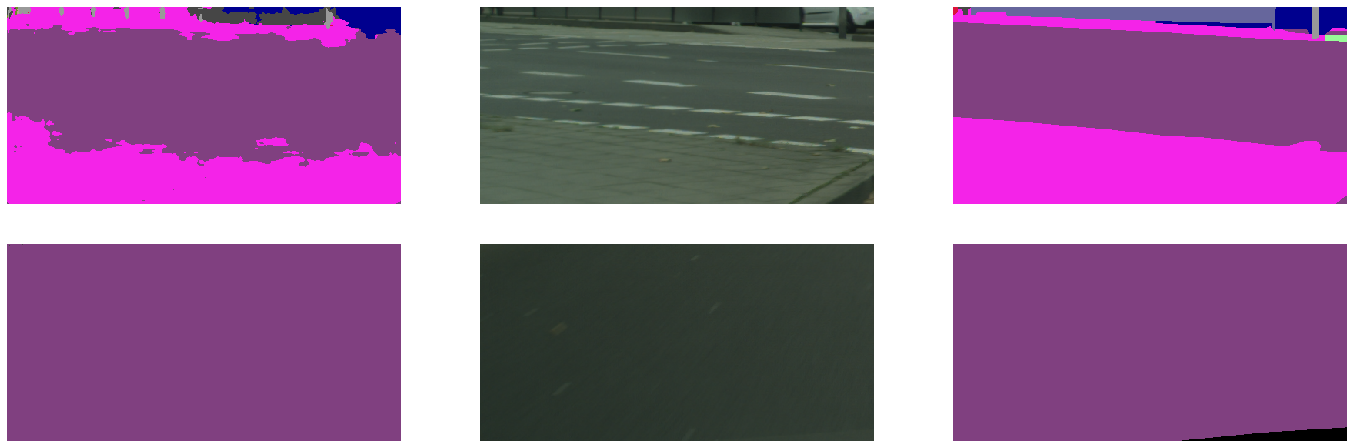

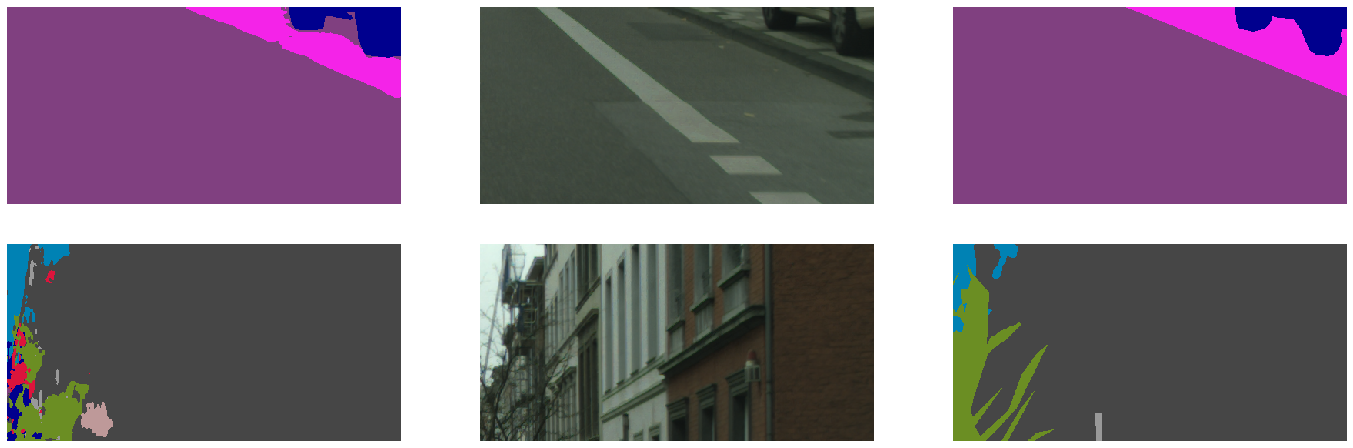

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


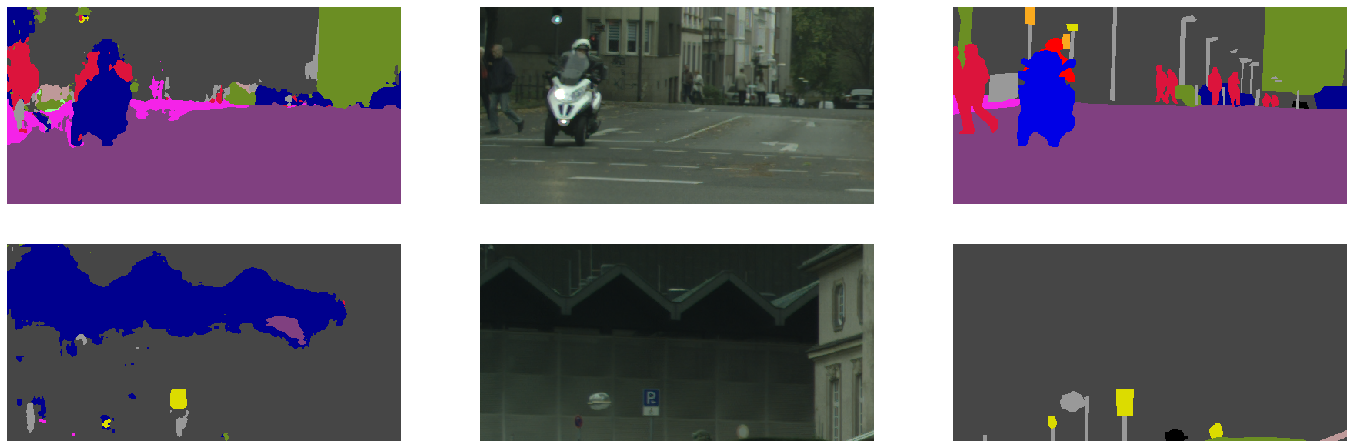

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


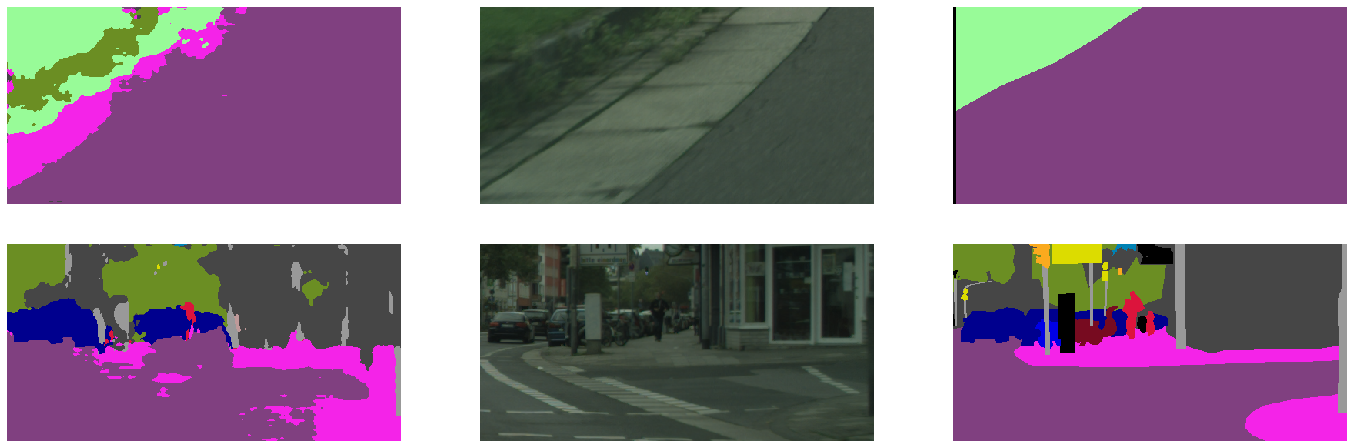

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


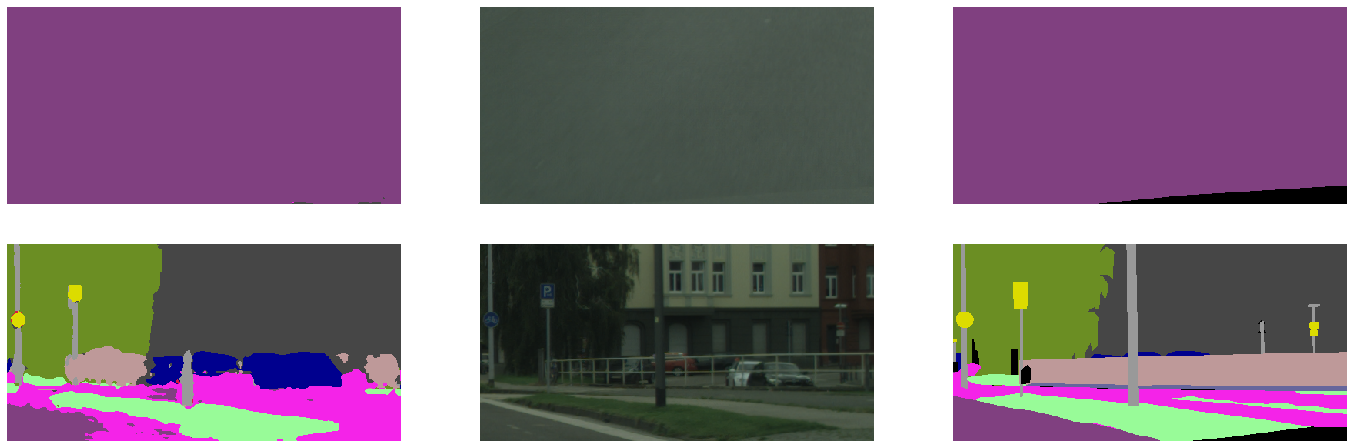

In [9]:
for imgs, lbls in dl_train:
    
    lbls = lbls.squeeze(dim=1)
    #preds
    preds = utils.predictionsFlattened(learner, imgs, device)
    
    utils.printSegmaps(imgs, lbls, preds)
    

In [10]:
np.unique(lbls)

array([-1,  0,  1,  2,  3,  4,  5,  7,  8,  9, 13], dtype=int64)

### Testing for Accuracy Metric

In [10]:
temp2 = lbls==-1

In [11]:
print(np.unique(lbls==preds.cpu()))
temp = lbls==preds.cpu()
temp3 = temp+temp2

[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


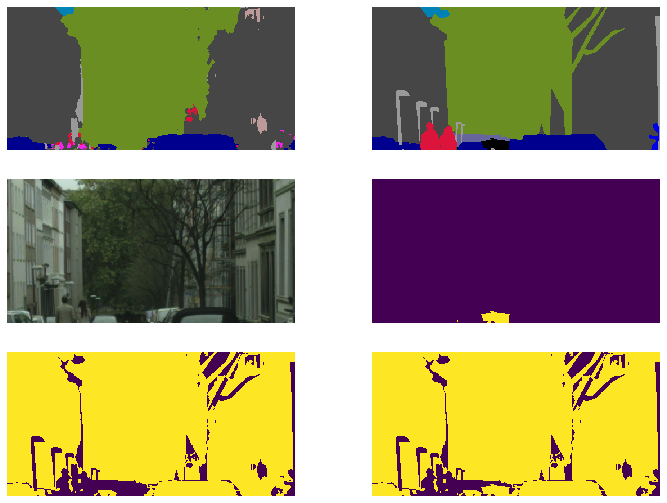

In [12]:
fig, ax = plt.subplots(3,2,figsize=(12,9))

ax[0][0].imshow(utils.decode_segmap(preds.cpu().numpy()[0]))
ax[0][1].imshow(utils.decode_segmap(lbls.cpu().numpy()[0]))
ax[1][0].imshow(np.transpose(imgs[0], [1,2,0]))
ax[1][1].imshow(temp2[0])
ax[2][0].imshow(temp[0])
ax[2][1].imshow(temp3[0])

ax[0][0].axis('off')
ax[1][0].axis('off')
ax[2][0].axis('off')
ax[0][1].axis('off')
ax[1][1].axis('off')
ax[2][1].axis('off')
plt.show()

In [13]:
total_pixels = lbls.shape[0] * lbls.shape[1]*lbls.shape[2]
correct_pixels = np.count_nonzero(temp3)
print(correct_pixels, total_pixels, correct_pixels/total_pixels)

221677 262144 0.8456306457519531


This second version is the correct definition of accuracy

In [14]:
unlabelled_pixels = np.count_nonzero(temp2)
total_pixels = lbls.shape[0] *lbls.shape[1]*lbls.shape[2] - unlabelled_pixels
correct_pixels = np.count_nonzero(temp)
print(unlabelled_pixels, correct_pixels, total_pixels, correct_pixels/total_pixels)

29979 191698 232165 0.8256972411862253


In [15]:
loss_metrics.accuracy(preds, lbls, ignore_class=-1)

0.8256972411862253

#### It Works!

### Tensor experiments

In [29]:
# one hot encode input
A = torch.tensor([[[[1.,2,3], [4,5,6], [7,8,9]], 
                   [[5.,6,7], [10,11,12], [20,22,25]], 
                   [[10,20,30], [40,50,60], [70,80,90]]]])
B = torch.tensor([[[0,1,0], [1,1,0], [1,0,0]]])
print(A.shape, ' ', B.shape)
t = A.detach() * 0
print(t.shape)
t.scatter_(1, B.unsqueeze(1), 1)
print(B)
# encoded_target.scatter_(1, lbls.unsqueeze(1), 1)

torch.Size([1, 3, 3, 3])   torch.Size([1, 3, 3])
torch.Size([1, 3, 3, 3])
tensor([[[0, 1, 0],
         [1, 1, 0],
         [1, 0, 0]]])


In [16]:
print(B.unsqueeze(1).shape)

torch.Size([1, 1, 3, 3])


In [17]:
m = nn.Softmax2d()
print(A)
print(m(A))

tensor([[[[ 1.,  2.,  3.],
          [ 4.,  5.,  6.],
          [ 7.,  8.,  9.]],

         [[10., 20., 30.],
          [40., 50., 60.],
          [70., 80., 90.]]]])
tensor([[[[1.2339e-04, 1.5230e-08, 1.8795e-12],
          [2.3195e-16, 2.8625e-20, 3.5326e-24],
          [4.3596e-28, 5.3802e-32, 6.6397e-36]],

         [[9.9988e-01, 1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00]]]])


In [33]:
sumA = A.sum(dim=1)
print(sumA)

tensor([[[ 16.,  28.,  40.],
         [ 54.,  66.,  78.],
         [ 97., 110., 124.]]])


In [34]:
A/sumA

tensor([[[[0.0625, 0.0714, 0.0750],
          [0.0741, 0.0758, 0.0769],
          [0.0722, 0.0727, 0.0726]],

         [[0.3125, 0.2143, 0.1750],
          [0.1852, 0.1667, 0.1538],
          [0.2062, 0.2000, 0.2016]],

         [[0.6250, 0.7143, 0.7500],
          [0.7407, 0.7576, 0.7692],
          [0.7216, 0.7273, 0.7258]]]])

### Dice Loss PoC - Expermient

In [21]:
imgs2 = imgs.to(device=device)
lbls2 = lbls.to(device=device)
full_pred = learner(imgs2)

RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 3.00 GiB total capacity; 1.75 GiB already allocated; 158.10 MiB free; 214.21 MiB cached)

In [ ]:
full_pred.shape

In [22]:
print(torch.min(full_pred))
print(torch.max(full_pred))

tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6858, device='cuda:0', grad_fn=<MaxBackward1>)


In [13]:
target = full_pred.detach() * 0
target.scatter_(1, lbls2.unsqueeze(1), 1)
print(target.shape)

torch.Size([2, 19, 256, 512])


In [15]:
print(torch.min(target))
print(torch.max(target))

RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at ..\aten\src\THC\THCGeneral.cpp:405

In [33]:
m = nn.Softmax2d()
full_pred = m(full_pred)
print(torch.min(full_pred))
print(torch.max(full_pred))

tensor(3.9523e-08, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.9970, device='cuda:0', grad_fn=<MaxBackward1>)


### Dice Loss Unit Test

In [13]:
imgs2 = imgs.to(device=device)
lbls2 = lbls.to(device=device)
full_pred = learner(imgs2)

In [23]:
lpc = loss_metrics.dice_loss_per_channel(full_pred, lbls2, ignore_index=-1, squishPreds=True)

In [15]:
s = full_pred.sum(dim=1).unsqueeze(1)
print(full_pred.shape, " ", s.shape)

torch.Size([2, 19, 256, 512])   torch.Size([2, 1, 256, 512])


In [16]:
(full_pred/s).sum(0).sum(1).sum(1)

tensor([40650.7422, 29895.6055, 46974.8359, 20589.4922, 16491.5547, 15489.9824,
            0.0000,  2876.0156, 25537.2402, 14290.1367,  2960.4009, 11047.2637,
            0.0000, 23574.2090, 11766.5166,     0.0000,     0.0000,     0.0000,
            0.0000], device='cuda:0', grad_fn=<SumBackward2>)

In [18]:
pred_flat = torch.argmax(full_pred, dim=1)
print(np.unique(pred_flat.cpu()))
print(np.unique(lbls2.cpu()))

[ 0  1  2  4  5  7  8  9 11 13]
[-1  0  1  2  3  4  5  7  8  9 13]


In [19]:
softmax = nn.Softmax2d()
pred_s = softmax(full_pred)
print(pred_s.sum(0).sum(1).sum(1))
print(full_pred.sum(0).sum(1).sum(1))

tensor([133572.0312,  19310.0684,  47888.5781,   1803.7925,   6465.4126,
          5015.8999,    271.3104,    645.3198,  25870.2109,  11510.4854,
           291.8800,    549.4165,    271.3104,   6928.1611,    664.8789,
           271.3104,    271.3104,    271.3104,    271.3104], device='cuda:0',
       grad_fn=<SumBackward2>)
tensor([1603466.5000, 1116066.2500, 1367681.8750,  679516.8750,  370343.5625,
         360720.5625,       0.0000,   56405.8984,  752118.2500,  469260.8125,
         115435.6875,  436624.1875,       0.0000,  771673.5000,  368596.8750,
              0.0000,       0.0000,       0.0000,       0.0000],
       device='cuda:0', grad_fn=<SumBackward2>)


In [24]:
print(np.unique(lbls))
for i in range(full_pred.size(1)):
    print(i, ' ', cd.class_names[i],' ', lpc[i].item())

[-1  0  1  2  3  4  5  7  8  9 13]
0   road   0.6034414768218994
1   sidewalk   0.8579031229019165
2   building   0.641464352607727
3   wall   0.9830596446990967
4   fence   0.871675431728363
5   pole   0.8687766194343567
6   traffic_light   0.0
7   traffic_sign   0.8721047639846802
8   vegetation   0.6689635515213013
9   terrain   0.7415564060211182
10   sky   0.9996483325958252
11   person   0.999907374382019
12   rider   0.0
13   car   0.9854139685630798
14   truck   0.9999128580093384
15   bus   0.0
16   train   0.0
17   motorcycle   0.0
18   bicycle   0.0


In [16]:
dice_l

tensor(0.8280, device='cuda:0', grad_fn=<DivBackward0>)